In [61]:
import json
import os
import pandas as pd

In [62]:
data_dir="C:/Users/tsb7592/Box/Baby Toolbox Operations/Domain Teams/Language/Tobii Pilot/LWL & EF Tobii Data Export"

In [63]:
os.chdir(data_dir)

In [64]:
tdf= pd.read_csv('Baby Toolbox_Data_Export_06_02_2021.tsv', sep='\t') 

C:\Users\tsb7592\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (28,34,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [68]:
tdf['ParticipantName'].value_counts()

ClaireP1    107784
BrianP2     101390
SKJ_P2       96213
Name: ParticipantName, dtype: int64

In [69]:
keep = [col for col in tdf.columns if 'AOI' in col]
keep = [col for col in keep if 'Calib' not in col]

In [70]:
k24 = keep[4:76]

In [83]:
def Separate_Person(df):
    '''
    Input: 
        df: the tsv file read to a pandas dataframe
    Output:
         results in a dictionary contains several pandas dataframe
    '''
    ppl = {}
    for person in df['ParticipantName'].unique():
        one = df[df['ParticipantName']==person][k24]
                 
        tdata = round(one.mean(),4).to_dict()
        left =[]
        right=[]
        away =[]
        onscreen = []
        
        j = 0
        for val in tdata:
            if j%3 == 0:
                rv = tdata[val]
                left.append(tdata[val])
            elif j%3 == 1:
                rv += tdata[val]
                right.append(tdata[val])
            else:
                rv = 1 - rv
                away.append(rv)
                onscreen.append(tdata[val])
            j+=1
                 
        exp = pd.DataFrame(columns=('left', 'right','onScreenAway','offScreenAway'))
        for i in range(24):
            lcol,rcol,wcol = k24[3*i:3*i+3]
    
            subset = one[one[wcol].notnull()]
    
            a=subset[lcol].sum()
            b=subset[rcol].sum()
            d=subset[(subset[lcol]==0) & (subset[rcol]==0) &(subset[wcol]==1)].shape[0]
            e=subset[(subset[lcol]==0) & (subset[rcol]==0) &(subset[wcol]==0)].shape[0]

            exp.loc[i] = [a, b ,d, e]
        ppl[person] = exp
    
                 
    return ppl

In [84]:
ppl = Separate_Person(tdf)

In [95]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('C:/Users/tsb7592/Box/Baby Toolbox Operations/Analysis/tsv_counts.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
ppl['ClaireP1'].to_excel(writer, sheet_name='Claire', index=False)
ppl['BrianP2'].to_excel(writer, sheet_name='Brian', index=False)
ppl['SKJ_P2'].to_excel(writer, sheet_name='SKJ', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Read json file

In [88]:
import json
import os
import pandas as pd

In [90]:
#claire
data_dir="C:/Users/tsb7592/Box/Baby Toolbox Operations/Domain Teams/Language/Tobii Pilot/Tobii Verbose Files/Claire"
os.chdir(data_dir)
df=pd.read_json('949BCA6A-D3D6-426C-9A94-E806F84E4E72@845BDD10-B9AF-4592-AA4E-0CCE76A0E8CD@00024@2021-05-11-22.11.48.356@LookListening@Claire@VerboseGazeData.json')

In [92]:
cols=['itemID','eventName','gazeLocationName', 'gazeLocationOnScreen',"lookAtPointX", "lookAtPointY"]

# Rewrite Lookalgorithm

In [113]:
#json file
obs = pd.DataFrame(columns=('L', 'R','onScreenAway','offScreenAway'))
items =[]
for i in range(len(end)):
    sub = df.iloc[begin[i]+1:end[i]]
    items.extend(sub.itemID.dropna().unique())
    a, b, c = sub.gazeLocationName.value_counts()[['left','right','away']].round(4) 
    if len(sub[sub['gazeLocationName'] == 'away'].gazeLocationOnScreen.value_counts()) == 2:
        d,e = sub[sub['gazeLocationName'] == 'away'].gazeLocationOnScreen.value_counts()
    else:
        d = c
        e = 0
    obs.loc[i] = [a, b ,d, e]

In [183]:
import math
import numpy as np

def lookAlgorithm(df, usevals, searchTime=1.0167, margX=10, margY=15, alignX=30, alignY=30):
    '''
    Input: 
        df: the json file read to a pandas dataframe
        usevals: a string of the column name
    Output:
         results in a pandas dataframe
    '''
    
    if 'lookAtPoint' in usevals:
        useX = "lookAtPointX"
        useY = "lookAtPointY"
    elif 'arHitTestLookAtPointPosition' in usevals:
        useX = "arHitTestLookAtPointPositionX"
        useY = "arHitTestLookAtPointPositionY"
    
    startRows =list(df[df['eventName'].str.contains('presentedCalibrationItem')].index)
    endRows =list(df[df['eventName'].str.contains('completedCalibrationItem')].index)
    
    if len(startRows) != len(endRows):
        print("Early-terminated Calibration")
        return
    
    RMs=[]
    for i in range(len(startRows)):
        rollingMeans = pd.DataFrame(columns=('Cali','calibFocal', 'rowIndex','rollingX','rollingY','props')) 
        sub = df.iloc[startRows[i]:endRows[i]+1]
        firstCheck_time = df.iloc[startRows[i]]['elapsedTime'] + searchTime
        firstCheck_row = sub[sub['elapsedTime'] <= firstCheck_time].index.max()
       
        for j in range(firstCheck_row, endRows[i]+1):
            rollingMeans.loc[j] = [i,'tmp', j, -9999,-9999, -9999]
            
            useData =sub[(sub['elapsedTime'] >= df.iloc[j]['elapsedTime'] - searchTime) & (sub['elapsedTime'] <= df.iloc[j]['elapsedTime'])&(sub['elapsedTime'] >= df.iloc[startRows[i]]['elapsedTime'])]
            useData = useData[~useData.eventName.str.contains('complet')]
                              
            rollingMeans.loc[j]['calibFocal']=useData['calibrationFocalPoint'].unique()[0]
            rollingMeans.loc[j]['rollingX']=round(useData[useX].mean(),2)
            rollingMeans.loc[j]['rollingY']=round(useData[useY].mean(),2)
            rollingMeans.loc[j]['props']=round(100*(useData[(useData[useX] >= useData[useX].mean()- margX) & (useData[useX] <= useData[useX].mean()+ margX) & (useData[useY] >= useData[useY].mean()- margY) & (useData[useY] <= useData[useY].mean()+ margY)]).shape[0]/useData[useData[useY].notnull()].shape[0],2)
          
        RMs.append(rollingMeans)
         
    RMs = pd.concat(RMs, ignore_index=True)
    
    use=[]
    for i in range(4):
        ur = RMs[(RMs['props'] >= 80) & (RMs['Cali']==i)].head(1)
        use.append(ur)
    useRows = pd.concat(use)
    useRows = useRows.reset_index()
    
    #if useRows.shape[0]>4:
    useRows['calibrationSet'] =(useRows.index + 1)/4
    useRows['calibrationSet'] =useRows['calibrationSet'].apply(np.ceil)
        
    tr = useRows[useRows['calibFocal']=='topRight']['rollingX'].values[0]
    br = useRows[useRows['calibFocal']=='bottomRight']['rollingX'].values[0]
    tl = useRows[useRows['calibFocal']=='topLeft']['rollingX'].values[0]
    bl = useRows[useRows['calibFocal']=='bottomLeft']['rollingX'].values[0]    
    
    #save the 4 screenSide numbers to a dictionary 
    screenSide={}
    if abs(tr- br) <= alignX:
        screenSide['rightSide'] = max(tr, br)
    else:
        screenSide['rightSide'] = np.NaN
    
    if abs(tl- bl) <= alignX:
        screenSide['leftSide']= min(tl, bl)
    else:
        screenSide['leftSide']= np.NaN
    
    tr = useRows[useRows['calibFocal']=='topRight']['rollingY'].values[0]
    br = useRows[useRows['calibFocal']=='bottomRight']['rollingY'].values[0]
    tl = useRows[useRows['calibFocal']=='topLeft']['rollingY'].values[0]
    bl = useRows[useRows['calibFocal']=='bottomLeft']['rollingY'].values[0]
    
    if abs(tr- tl) <= alignY:
        screenSide['topSide'] = round((tr+tl)/2,2)
    else:
        screenSide['topSide'] = np.NaN
        
    if abs(br- bl) <= alignY:
        screenSide['bottomSide']= round((br+bl)/2,2)
    else:
        screenSide['bottomSide']= np.NaN   
        
    if useRows['calibFocal'].isnull().any():
        screenSide['rightSide'] = np.NaN
        screenSide['leftSide'] = np.NaN
        screenSide['topSide'] = np.NaN
        screenSide['bottomSide'] = np.NaN
 
    return RMs,useRows,screenSide

In [96]:
RM, lookDetected, ss=lookAlgorithm(df,'lookAtPoint')

In [97]:
RM

,Cali,calibFocal,rowIndex,rollingX,rollingY,props
0,0,topLeft,89,32.1,10.86,35.48
1,0,topLeft,90,31.78,10.76,33.87
2,0,topLeft,91,31.61,10.48,35.0
3,0,topLeft,92,31.4,10.57,32.79
4,0,topLeft,93,31.07,10.51,32.79
...,...,...,...,...,...,...
275,3,topRight,594,114.78,0.84,100.0
276,3,topRight,595,114.66,0.66,100.0
277,3,topRight,596,114.57,0.46,100.0
278,3,topRight,597,114.47,0.39,100.0


# Modify the numbers

In [99]:
def Modify_screenSide(ss, ratio= 0.45, leftright= 25, topbottom=50):
    '''
    Input: 
        ss: dictionary contains the four screensides
        leftright: the margin to modify the left/right side
        topbottom: the margin to modify the top/bottom side
        ratio: the ratio to identify left and right side
        
    Output:
        screenSide: the modified dictionary contains new four screensides
    '''
    screenSide =ss.copy()
    screenSide['rightSide'] += leftright
    screenSide['leftSide'] -= leftright
    screenSide['topSide'] -= topbottom
    screenSide['bottomSide'] += topbottom
    
    leftM = (screenSide['rightSide']-screenSide['leftSide'])*ratio
    rightM = (screenSide['rightSide']-screenSide['leftSide'])*(1-ratio)
    print('Margin for ratio: ',ratio, leftM, rightM)
    
    return screenSide

In [100]:
def Location(row, ss, ratio):
    leftM = (ss['rightSide']-ss['leftSide'])*ratio
    rightM = (ss['rightSide']-ss['leftSide'])*(1-ratio)
    if row['lookAtPointX'] > ss['leftSide'] and row['lookAtPointX'] <leftM  and row['lookAtPointY']>ss['topSide']and row['lookAtPointY']<ss['bottomSide'] :
        return 'left'
    elif row['lookAtPointX'] > rightM  and row['lookAtPointX'] <ss['rightSide'] and row['lookAtPointY']>ss['topSide']and row['lookAtPointY']<ss['bottomSide']:
        return 'right'
    else:
        return 'away'

In [101]:
def OnScreen(row, ss, ratio):
    leftM = (ss['rightSide']-ss['leftSide'])*ratio
    rightM = (ss['rightSide']-ss['leftSide'])*(1-ratio)
    if row['lookAtPointX'] >leftM and row['lookAtPointX']< rightM and row['lookAtPointY']<ss['bottomSide']and row['lookAtPointY']>ss['topSide'] :
        return 'true'
    else:
        return 'false'

In [104]:
cols=['itemID',
 'eventName',
 'gazeLocationName',
 'gazeLocationOnScreen',
 'lookAtPointX',
 'lookAtPointY','NewLocation','NewOnScreen']

In [185]:
#json file

def ReProcess(data, ss, ratio):
    '''
    Input: 
        df: the json file read to a pandas dataframe
        ss: the modified dictionary contains new four screensides
        ratio: the ratio to identify left and right side
        
    Output:
         new: the pandas dataframe contains the new count 
         items: a list of the name of the N items
    '''
    #Finding the index for presentLiveItem and completeLiveItem to subset the pieces we need for analysis
    df = data.copy()

    df['NewLocation'] = df.apply( lambda row : Location(row, ss, ratio), axis = 1)
    df['NewOnScreen'] = df.apply( lambda row : OnScreen(row, ss, ratio), axis = 1)
    item_index = []

    new = pd.DataFrame(columns=('L', 'R','onA','offA'))
    items =[]
    for i in range(len(end)):
        sub = df.iloc[begin[i]+1:end[i]]
        items.extend(sub.itemID.dropna().unique())
        
        lindex=sub[['gazeLocationName', 'gazeLocationOnScreen','lookAtPointX','lookAtPointY']].dropna().index
        sub = sub.loc[lindex]
        item_index.append(lindex)
        sub = sub[['NewLocation', 'NewOnScreen','lookAtPointX','lookAtPointY']].dropna()
        #when one location is zero count
        if sub.NewLocation.nunique() ==2:
            if 'right' not in (sub.NewLocation.unique()):
                a, c = sub.NewLocation.value_counts()[['left','away']].round(4) 
                b = 0
            elif 'left' not in (sub.NewLocation.unique()):
                b, c = sub.NewLocation.value_counts()[['right','away']].round(4) 
                a = 0
            else:
                a, b = sub.NewLocation.value_counts()[['left','right']].round(4) 
                c = 0   
                
        elif sub.NewLocation.nunique() ==1:
            if 'right' in (sub.NewLocation.unique()):
                a = 0
                c =0
                b = sub.NewLocation.value_counts().round(4) 
            elif 'left'  in (sub.NewLocation.unique()):
                b = 0
                c = 0
                a = sub.NewLocation.value_counts().round(4) 
            else:
                a = 0
                b = 0
                c = sub.NewLocation.value_counts().round(4)    
        else:
            a, b, c = sub.NewLocation.value_counts()[['left','right','away']].round(4) 
            
        if len(sub[sub['NewLocation'] == 'away'].NewOnScreen.value_counts()) == 2:
            d,e = sub[sub['NewLocation'] == 'away'].NewOnScreen.value_counts()
        else:
            d = c
            e = 0
        new.loc[i] = [a, b ,d, e]
     
    
    return new, df, items, item_index

# Euler Angle

In [106]:
euler=['arEulerAngleFaceX', 'arEulerAngleFaceY', 'arEulerAngleFaceZ']

In [107]:
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew

EA = []
for i in range(len(end)):
    sub = df.iloc[begin[i]+1:end[i]][euler].dropna()
    print(items[i])
    summary = sub.describe()[1:3]
    summary.loc['Kurtosis'] = kurtosis(sub)
    summary.loc['Skew'] = skew(sub)
    display(summary)
    EA.append(summary)

Shoulder_Hose_G5


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.016042,0.105156,0.056655
std,0.073443,0.061616,0.035063
Kurtosis,-1.328017,-0.288318,-0.679476
Skew,-0.043950,-0.734964,-0.009703


Ladder_Melon_G5


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.040761,0.205920,-0.002911
std,0.053658,0.162100,0.035259
Kurtosis,1.712758,0.551409,-0.670923
Skew,-1.171197,1.358672,-0.496988


Rooster_Playground_G5


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.010905,0.085573,0.020747
std,0.059262,0.111691,0.088701
Kurtosis,0.719910,-1.065274,-0.626506
Skew,0.910714,-0.614036,0.482929


Tricycle_Sneaker_G5


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.031980,0.027270,0.144209
std,0.093615,0.077202,0.104649
Kurtosis,1.515859,-0.888548,1.198509
Skew,0.789121,-0.858333,1.473389


Hose_Shoulder_G5


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.098668,0.076826,-0.045378
std,0.045777,0.063790,0.074273
Kurtosis,-0.191110,-0.313478,0.131153
Skew,-0.694129,-1.010555,-1.317651


Melon_Ladder_G5


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.054090,0.066129,-0.093846
std,0.054293,0.102933,0.106741
Kurtosis,0.523238,-0.630725,2.683381
Skew,0.719763,0.469171,-1.889050


Playground_Rooster_G5


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.015085,0.158313,-0.083441
std,0.079736,0.022161,0.104698
Kurtosis,-0.376237,0.522172,-0.649132
Skew,-0.764243,0.279071,-0.735480


Sneaker_Tricycle_G5


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,-0.000167,0.025936,0.073881
std,0.060891,0.175824,0.140699
Kurtosis,0.024947,-0.684815,-0.228630
Skew,0.545732,-1.051888,1.028465


Star_Moose_G6


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.017004,0.198033,0.025853
std,0.071851,0.098941,0.071773
Kurtosis,0.831416,0.644818,0.365708
Skew,0.032138,1.250332,1.198250


Turtle_Hammer_G6


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.046667,0.150081,-0.073887
std,0.102652,0.047271,0.137497
Kurtosis,1.238960,4.925112,-1.059961
Skew,1.209979,2.070478,-0.852090


Cake_Bee_G6


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.023741,0.123450,-0.113590
std,0.035088,0.059565,0.101295
Kurtosis,1.480139,0.185204,1.789650
Skew,-1.151930,-1.002735,-1.630619


Lamp_Stove_G6


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.026348,0.060992,0.021517
std,0.119730,0.072475,0.194978
Kurtosis,-0.016953,2.425804,0.894552
Skew,0.764713,-1.788936,-0.579200


Moose_Star_G6


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.051477,0.106550,-0.063472
std,0.015219,0.061384,0.109106
Kurtosis,0.285653,1.900278,-0.881335
Skew,-0.433464,1.238113,-0.791509


Hammer_Turtle_G6


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.105640,0.057702,-0.115379
std,0.109860,0.125756,0.155379
Kurtosis,0.693954,-0.259245,0.932646
Skew,1.290152,-0.987246,-1.402514


Bee_Cake_G6


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.014883,0.083278,-0.003820
std,0.060976,0.024094,0.012675
Kurtosis,-0.409396,-0.627558,0.002435
Skew,-0.880497,-0.451892,-0.628035


Stove_Lamp_G6


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,-0.046196,0.116605,0.048116
std,0.064950,0.128680,0.122323
Kurtosis,0.674482,2.904834,0.315646
Skew,-0.148202,-0.163882,1.257020


Garden_Sweater_G7


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.025674,0.086958,0.105928
std,0.066803,0.110656,0.181309
Kurtosis,0.346272,-1.012936,0.027977
Skew,1.059181,-0.533615,1.215245


Ankle_Scissors_G7


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.041551,0.102697,-0.046005
std,0.086312,0.038281,0.050300
Kurtosis,0.794656,-0.248113,-0.288428
Skew,1.389174,-0.942253,-0.964019


Woods_Tray_G7


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.079602,0.047311,-0.002517
std,0.024945,0.033971,0.017113
Kurtosis,0.949332,-0.457836,-0.411410
Skew,-0.272296,0.208512,0.128790


Bench_Rip_G7


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.153623,0.113402,0.200321
std,0.082426,0.109593,0.194279
Kurtosis,-0.440196,-1.073630,0.137603
Skew,-0.047247,0.150437,0.912630


Sweater_Garden_G7


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.003756,0.096548,0.024924
std,0.036564,0.034382,0.021185
Kurtosis,-0.234550,-0.807045,-0.700486
Skew,0.444920,0.364545,0.364065


Scissors_Ankle_G7


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.053671,0.067290,-0.028022
std,0.027051,0.093791,0.105272
Kurtosis,1.411465,-0.710593,0.141894
Skew,0.881281,-0.946447,-1.317226


Tray_Woods_G7


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.049345,0.092111,-0.025921
std,0.024402,0.023582,0.017721
Kurtosis,2.305433,-0.197257,-0.718545
Skew,1.496058,0.695441,-0.487519


Rip_Bench_G7


,arEulerAngleFaceX,arEulerAngleFaceY,arEulerAngleFaceZ
mean,0.129143,0.106811,-0.020187
std,0.097436,0.120918,0.047884
Kurtosis,3.828935,8.584933,13.232644
Skew,2.084855,2.624298,-3.155102


In [108]:
EulerAngle = pd.concat(EA)
#EulerAngle.to_csv('C:/Users/tsb7592/Box/Baby Toolbox Operations/Analysis/EulerAngleStats.csv', index=False)

In [149]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline


def plot_dots(df, title, ss, nss, ratio=0.4):
    leftM = (nss['rightSide']-nss['leftSide'])*ratio
    rightM = (nss['rightSide']-nss['leftSide'])*(1-ratio)
    
    width = ss['rightSide'] - ss['leftSide']
    height = ss['bottomSide'] - ss['topSide']
    
    w1= leftM- nss['leftSide']
    h1= nss['bottomSide']- nss['topSide']
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    
    #color by different category
    OA =df[(df['NewLocation'] == 'away') & (df['NewOnScreen']=='true')]
    ax1.scatter(x=OA.lookAtPointX, y=OA.lookAtPointY,alpha=0.9, color='blue',marker='+')
    
    FA =df[(df['NewLocation'] == 'away') & (df['NewOnScreen']=='false')]
    ax1.scatter(x=FA.lookAtPointX, y=FA.lookAtPointY,alpha=0.9, color='black',marker="1")
    
    LR =df[(df['NewLocation'] == 'left') | (df['NewLocation']=='right')]
    ax1.scatter(x=LR.lookAtPointX, y=LR.lookAtPointY,alpha=0.9, color='orange', marker='.')

    ax1.add_patch(patches.Rectangle((nss['leftSide'], nss['topSide']), w1, h1,color='red',fill=False))
    ax1.add_patch(patches.Rectangle(( rightM, nss['topSide']), w1, h1,color='red',fill=False))
    
    ax1.add_patch( patches.Rectangle((ss['leftSide'], ss['topSide']), width, height, color='green', fill=False))
    plt.title(title)
    
    ymax = (nss['topSide']//10)*10
    ymin =(nss['bottomSide']//10+1)*10
    xmin =(nss['leftSide']//10-1)*10
    xmax = (nss['rightSide']//10+1)*10
    
    plt.ylim((ymin,ymax))
    plt.xlim((-10,150))
    plt.show()

In [139]:
nss

{'rightSide': 138.45,
 'leftSide': 0.3299999999999983,
 'topSide': -42.12,
 'bottomSide': 66.38}

In [148]:
(nss['leftSide']//10-1)*10

-10.0

In [186]:
def Run_different(df, key):
    margins = [0.4, 0.425,0.45]
    _, _, ss=lookAlgorithm(df,'lookAtPoint')
    
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    filedir ='C:/Users/tsb7592/Box/Baby Toolbox Operations/Analysis/'+key+'_counts.xlsx'
    writer = pd.ExcelWriter(filedir, engine='xlsxwriter')
    
    for mar in margins:
        nss= Modify_screenSide(ss, mar)
        new, dfm, items, indexm =ReProcess(df, nss, mar)
        
        # Write each dataframe to a different worksheet
        pd.concat([ppl[key], new], axis=1).to_excel(writer, sheet_name=str(mar), index=False)
        for i in range(24):
            sub = dfm.loc[indexm[i]]
            plot_dots(sub, items[i], ss, nss)

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    
    return
    

Margin for ratio:  0.4 55.248000000000005 82.872


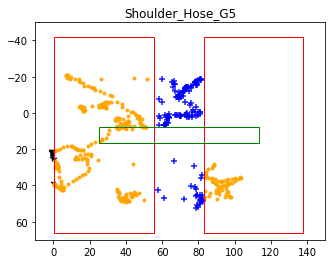

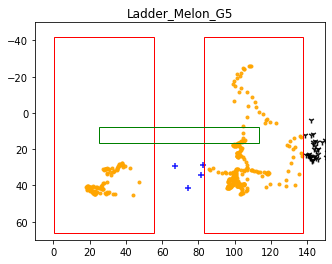

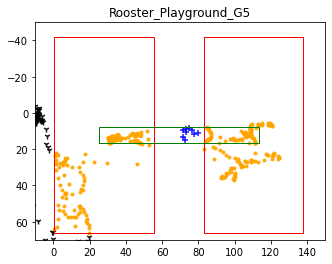

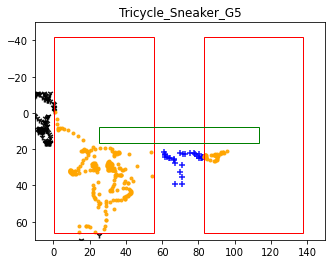

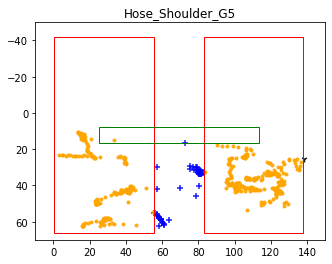

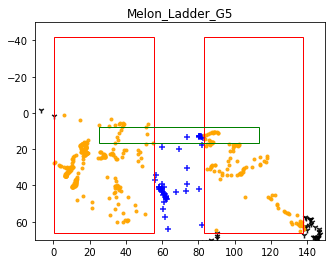

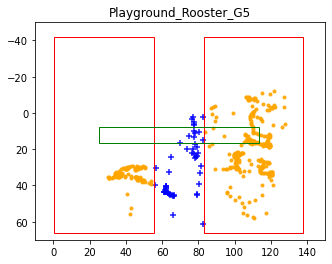

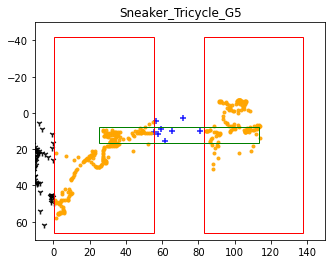

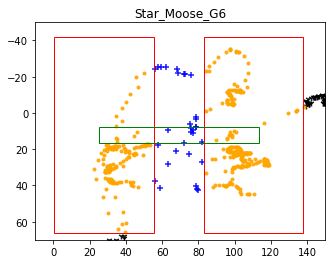

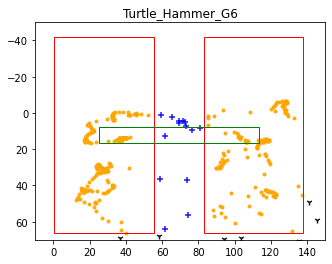

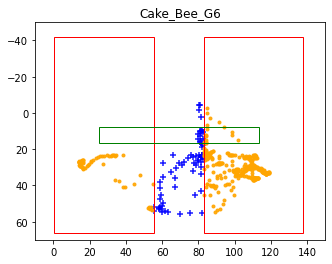

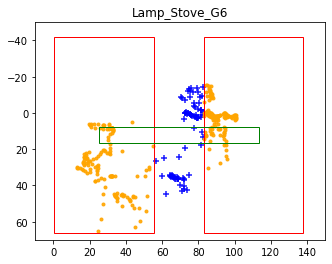

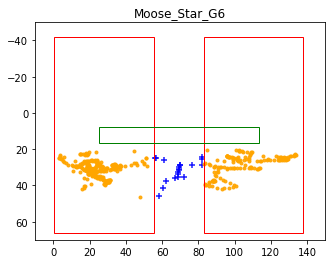

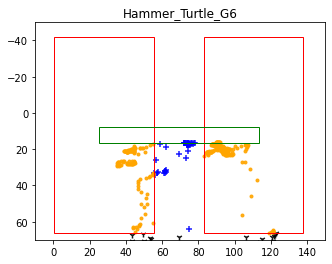

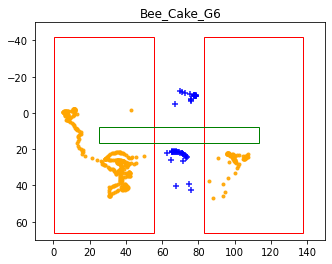

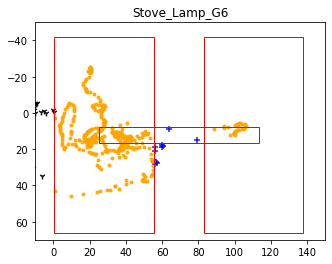

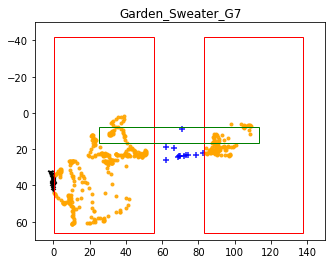

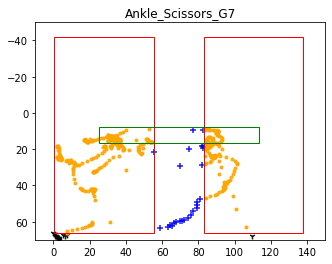

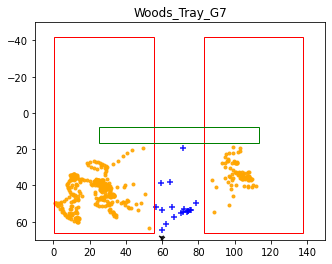

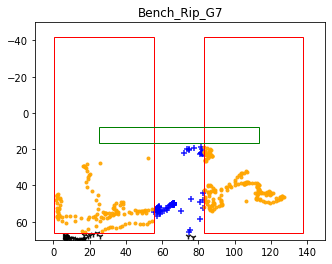

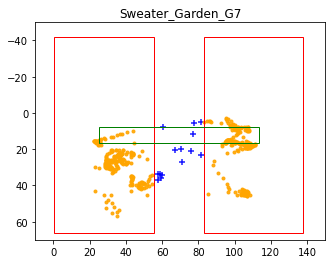

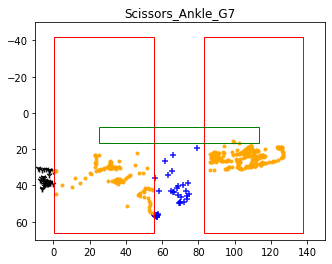

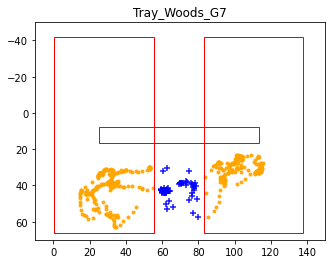

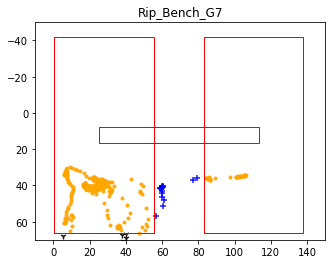

In [126]:
#Claire
Run_different(df, 'ClaireP1')

In [161]:
#Sheila
data_dir="C:/Users/tsb7592/Box/Baby Toolbox Operations/Domain Teams/Language/Tobii Pilot/Tobii Verbose Files/Sheila"
os.chdir(data_dir)
sdf=pd.read_json('B8C654C6-5EAA-452E-8A80-B0281F7533C8@845BDD10-B9AF-4592-AA4E-0CCE76A0E8CD@00030@2021-05-12-00.31.22.201@LookListening@SKJ@VerboseGazeData.json')

Margin for ratio:  0.4 49.19200000000001 73.788


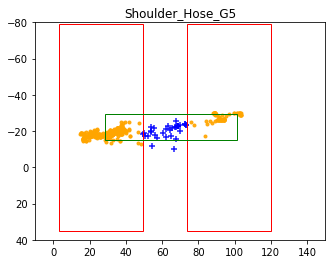

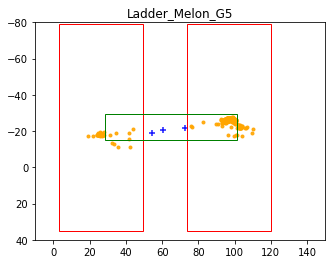

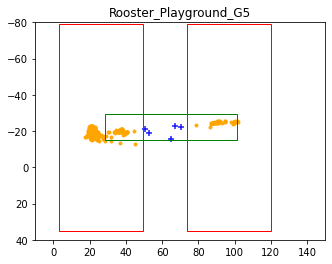

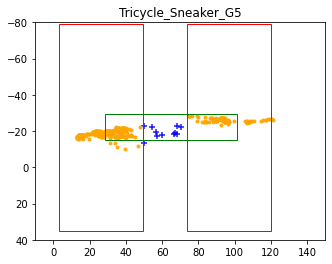

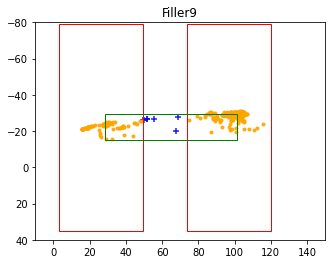

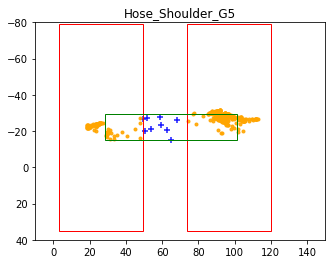

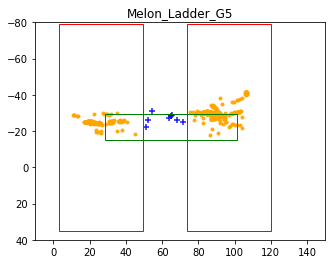

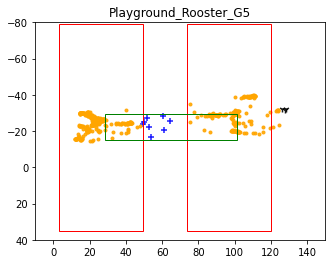

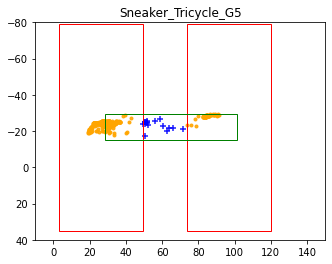

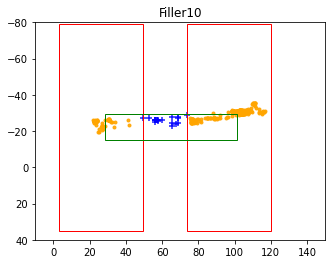

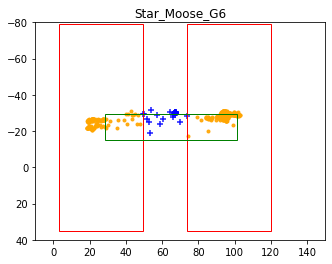

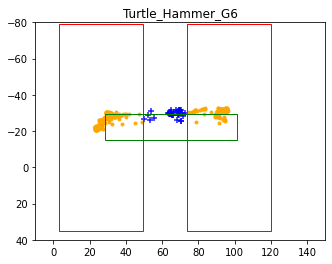

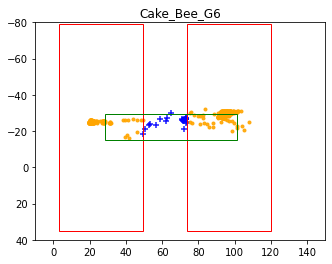

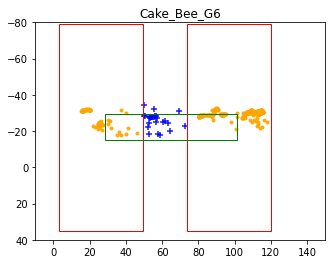

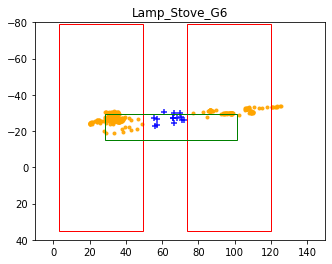

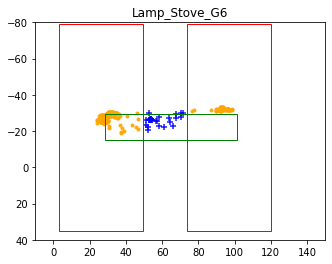

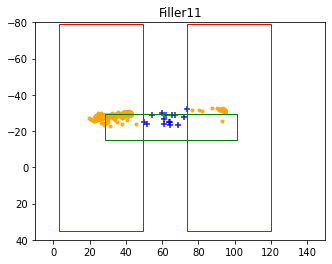

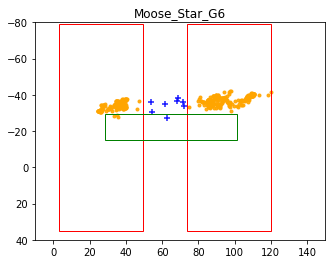

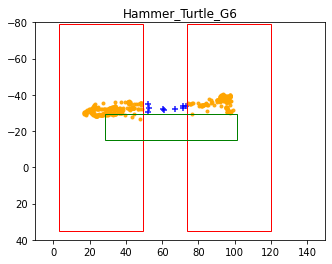

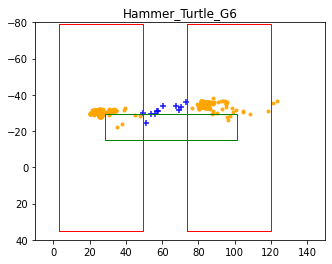

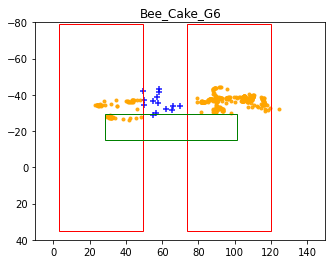

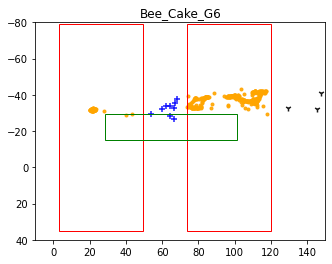

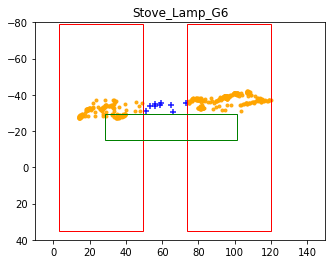

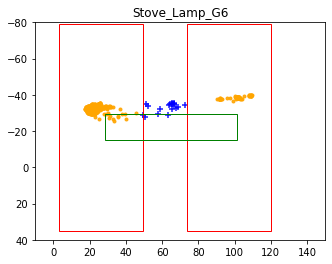

Margin for ratio:  0.425 52.2665 70.7135


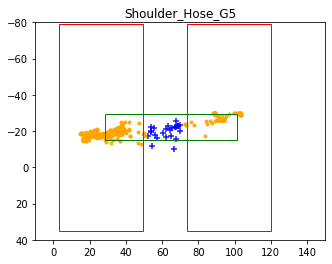

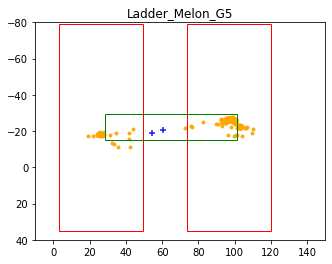

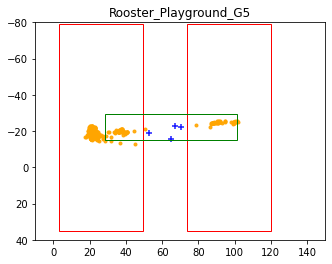

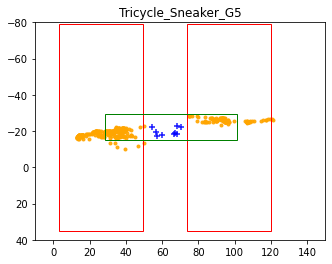

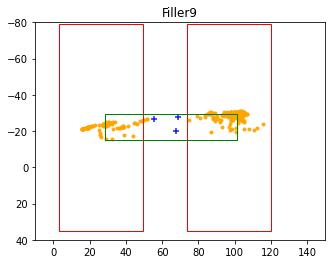

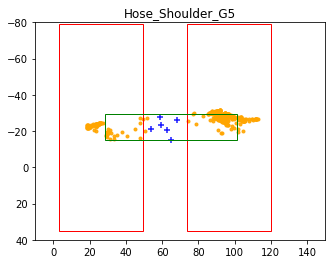

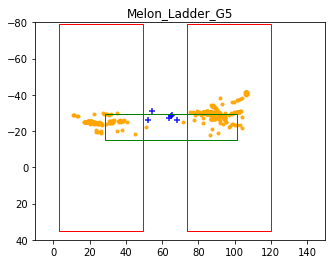

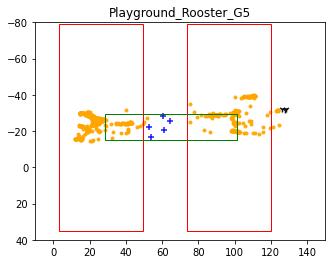

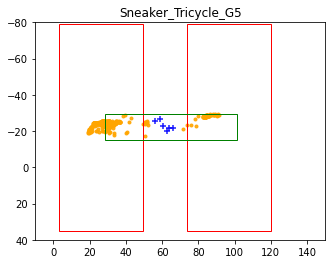

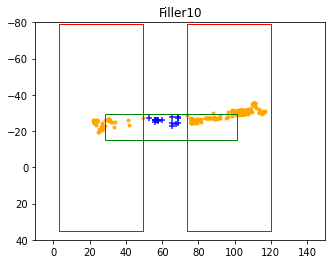

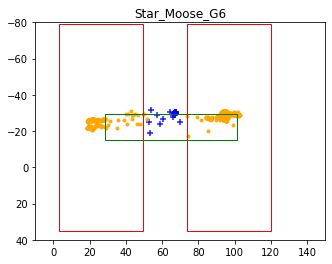

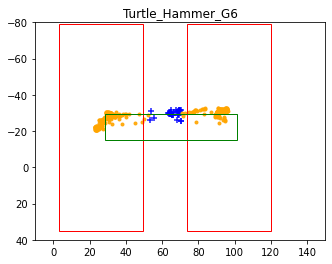

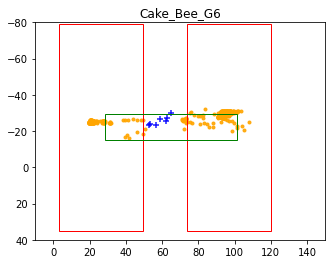

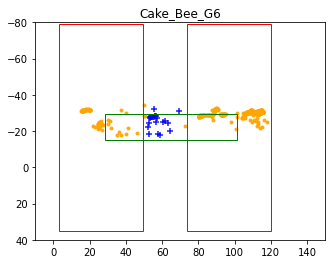

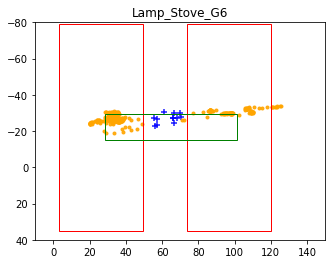

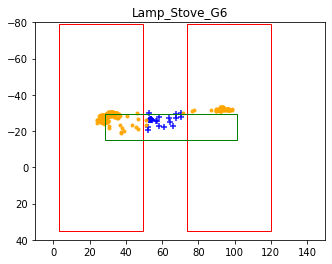

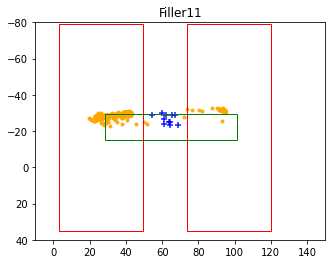

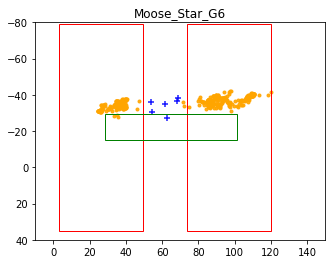

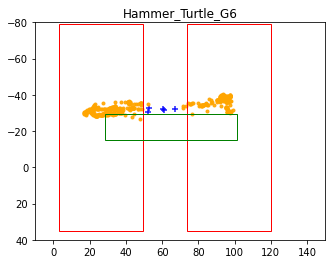

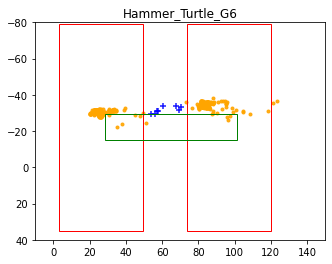

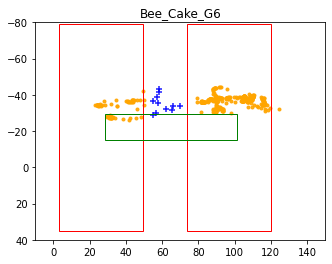

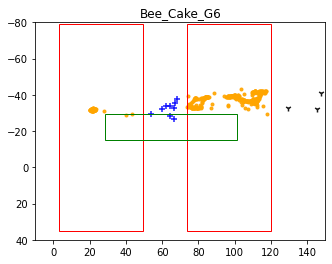

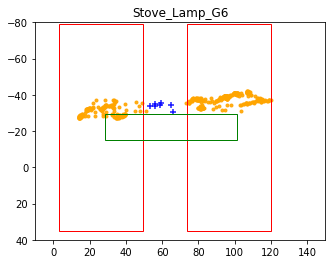

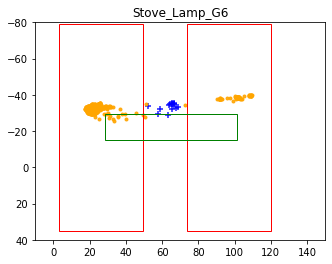

Margin for ratio:  0.45 55.341 67.63900000000001


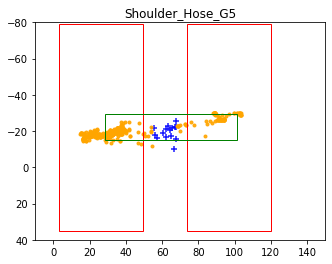

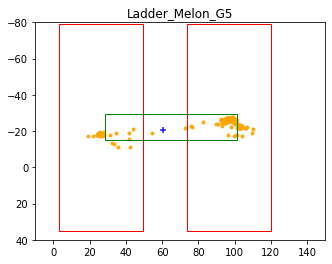

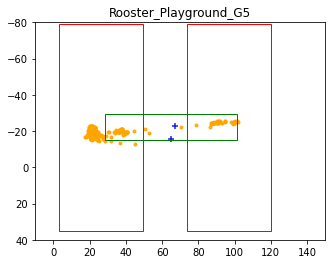

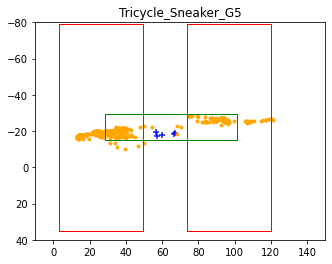

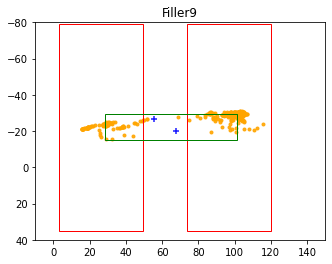

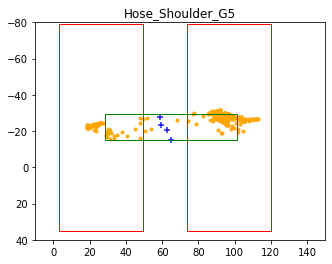

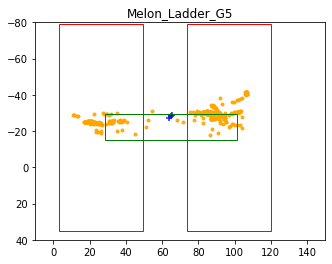

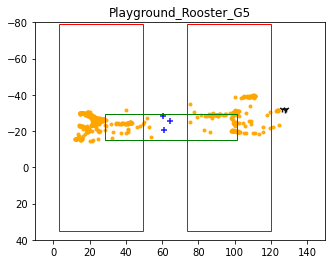

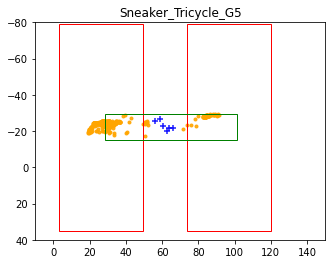

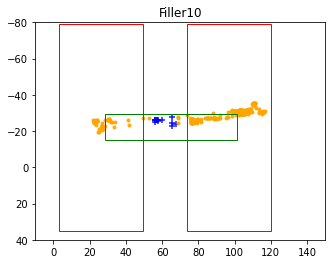

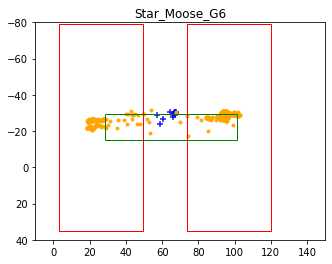

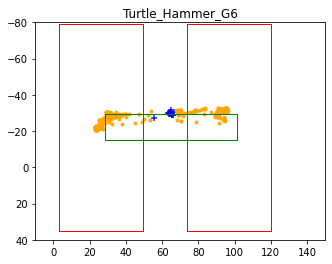

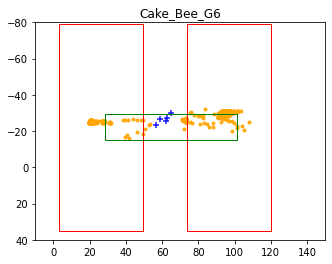

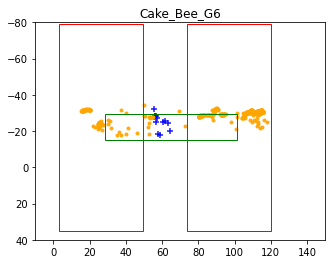

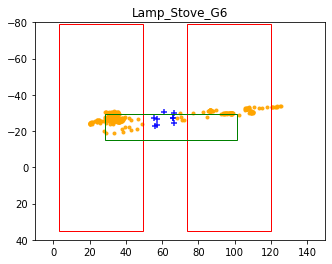

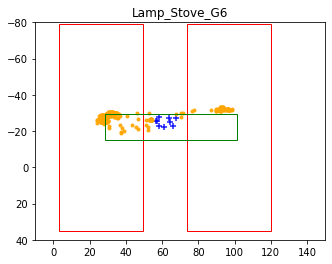

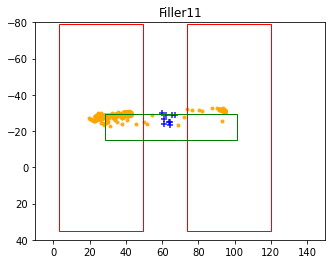

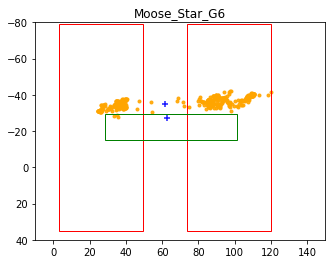

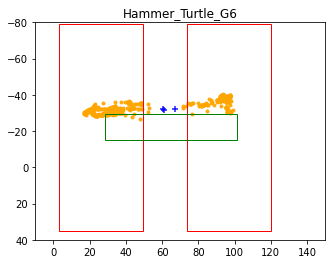

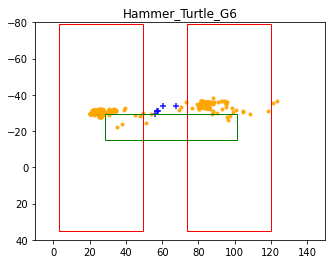

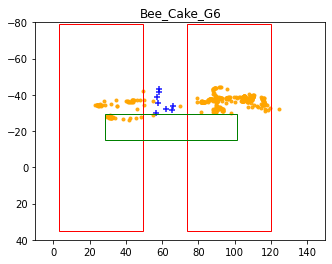

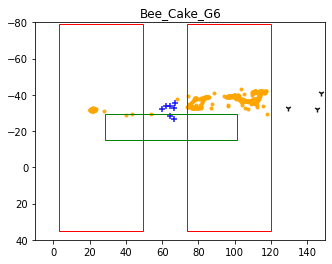

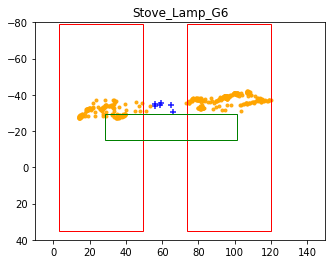

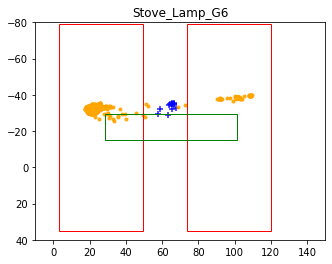

In [162]:
#Sheila
Run_different(sdf, 'SKJ_P2' )

In [163]:
#Brian
data_dir="C:/Users/tsb7592/Box/Baby Toolbox Operations/Domain Teams/Language/Tobii Pilot/Tobii Verbose Files/Brian"
os.chdir(data_dir)
bdf=pd.read_json('A87CEC62-214F-4B81-A3CB-45B1DA445644@845BDD10-B9AF-4592-AA4E-0CCE76A0E8CD@00026@2021-05-12-00.13.17.121@LookListening@Brian@VerboseGazeData.json')

Margin for ratio:  0.4 52.407999999999994 78.61199999999998


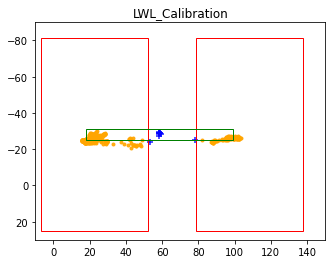

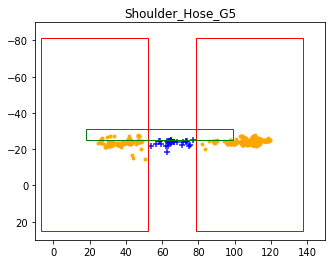

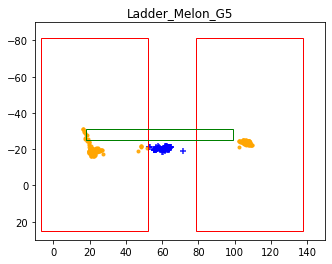

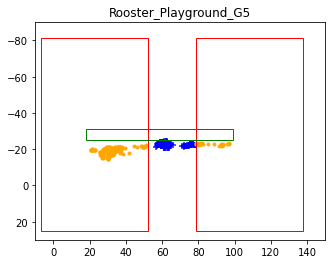

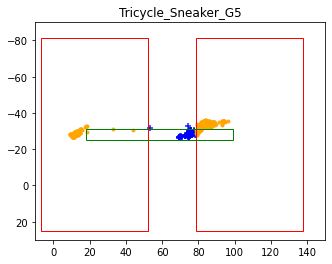

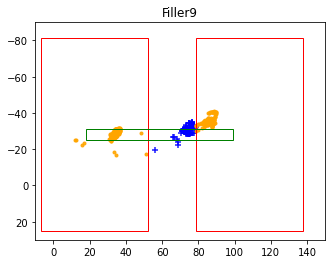

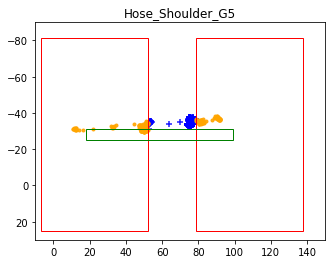

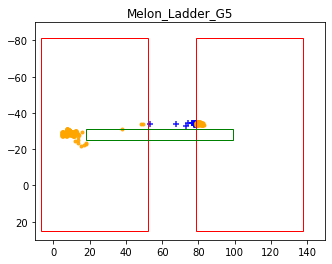

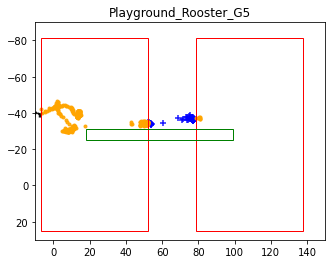

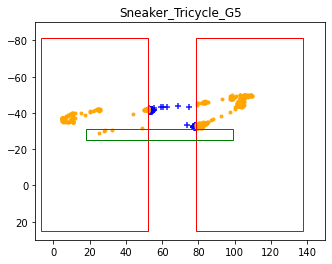

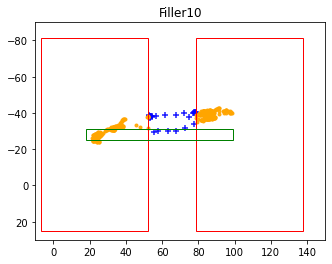

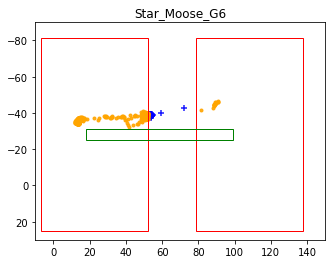

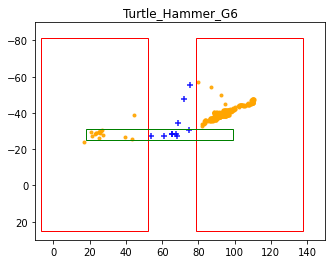

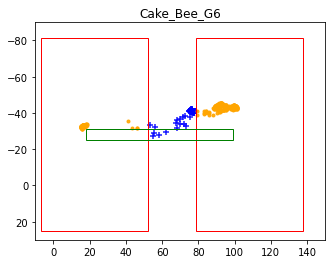

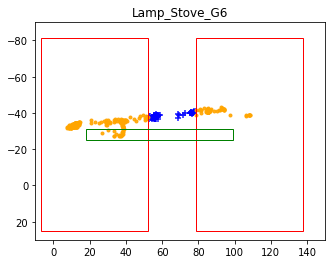

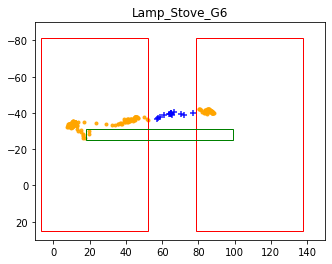

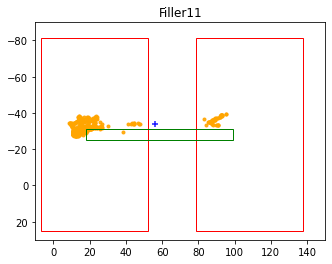

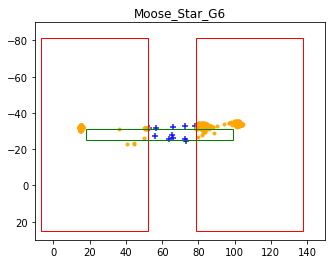

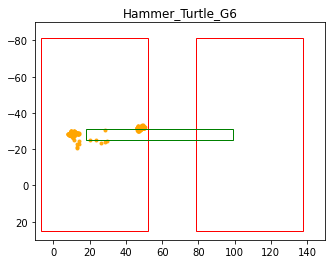

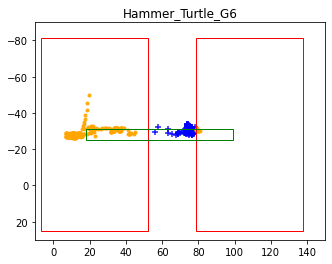

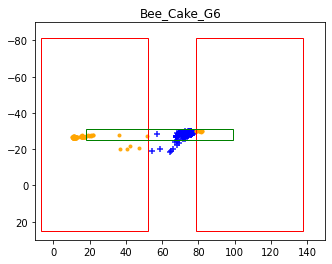

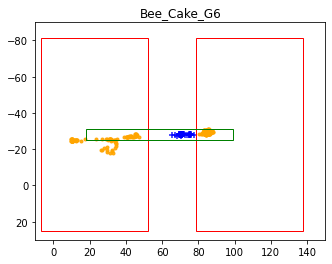

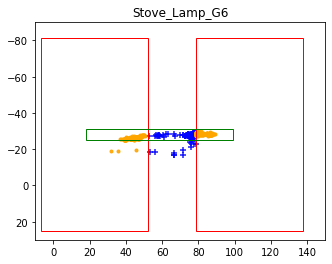

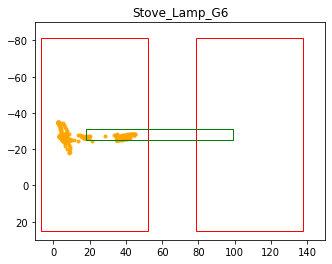

Margin for ratio:  0.425 55.68349999999999 75.33649999999999


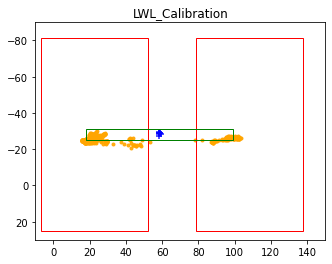

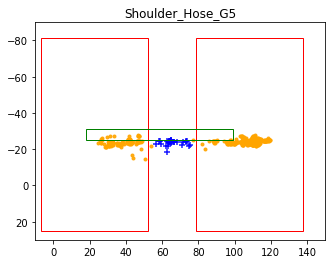

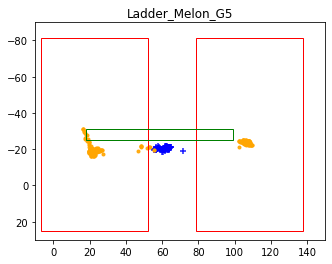

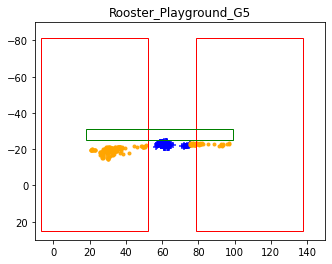

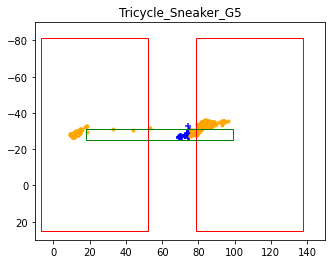

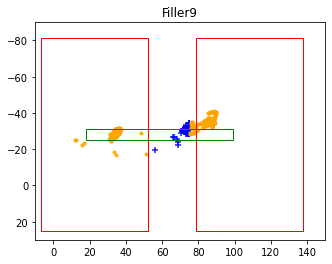

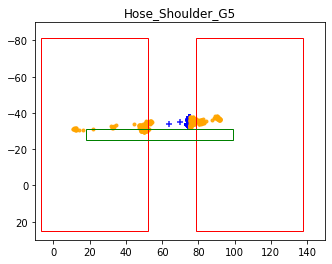

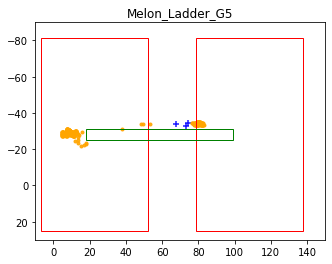

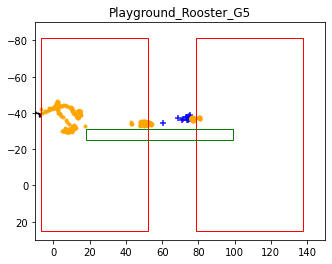

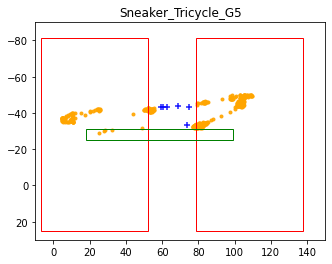

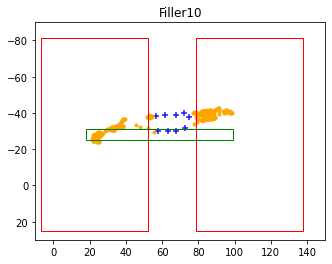

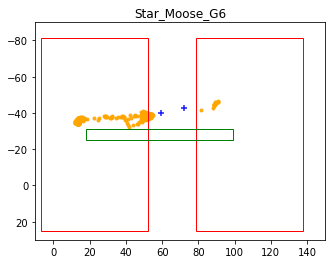

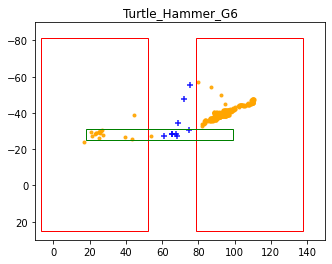

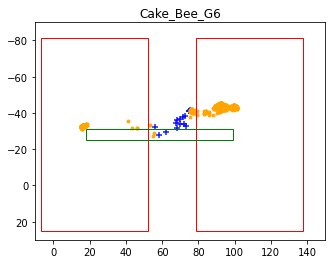

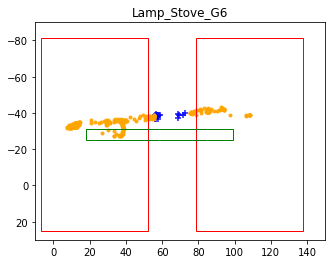

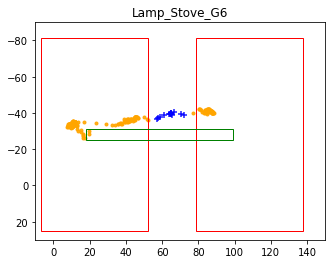

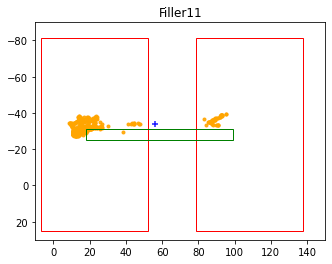

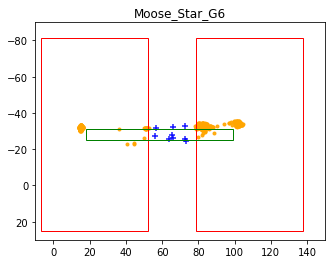

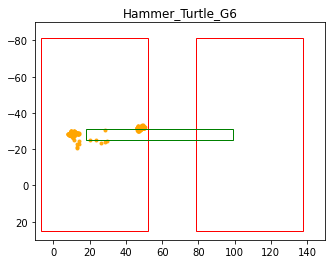

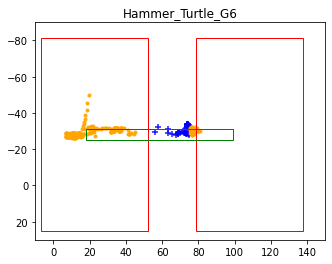

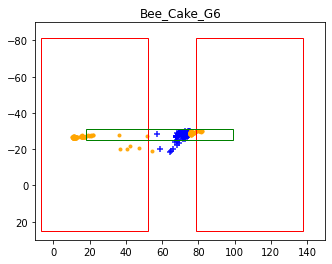

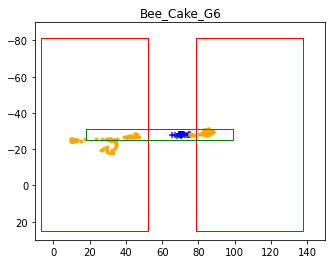

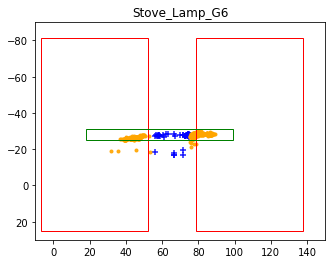

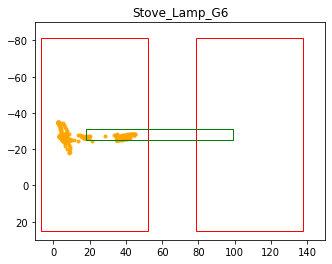

Margin for ratio:  0.45 58.958999999999996 72.06099999999999


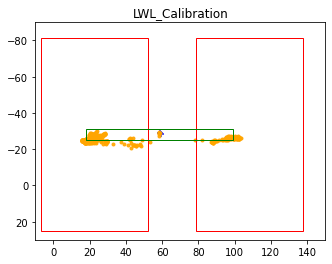

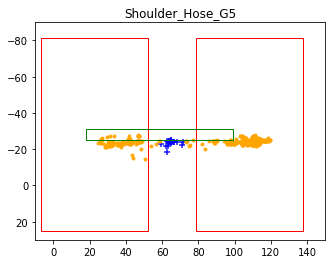

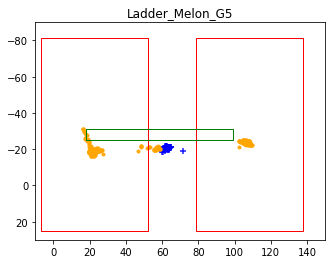

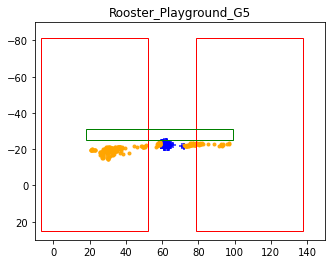

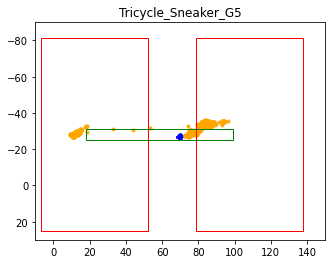

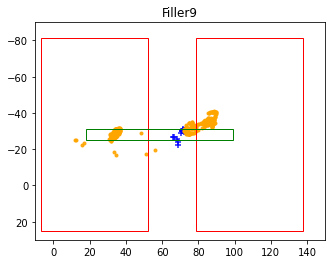

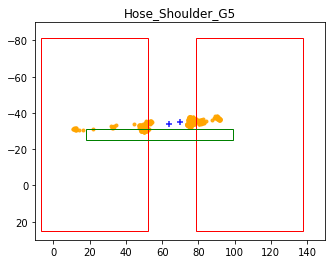

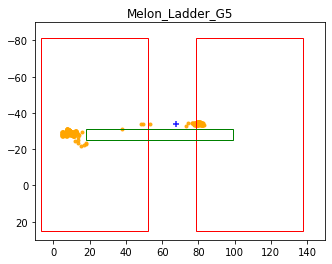

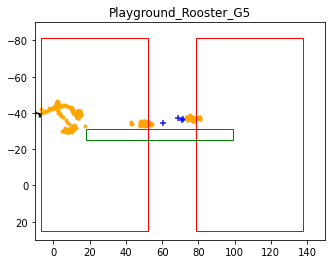

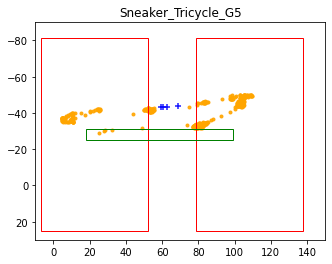

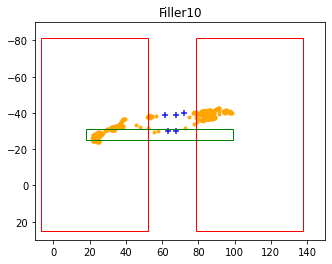

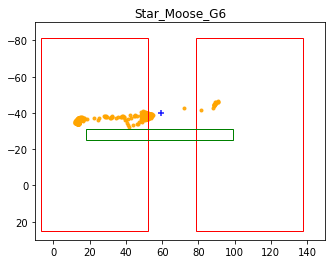

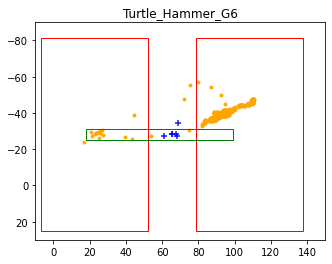

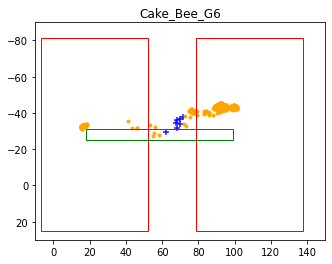

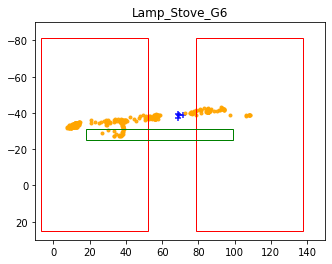

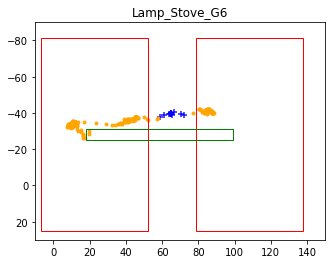

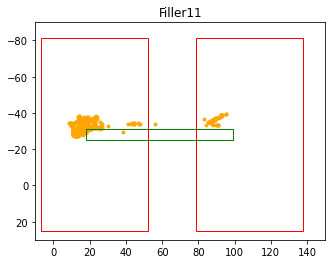

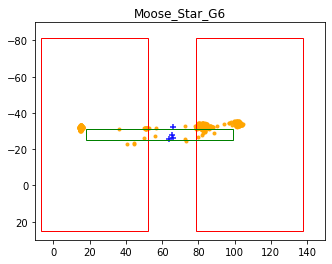

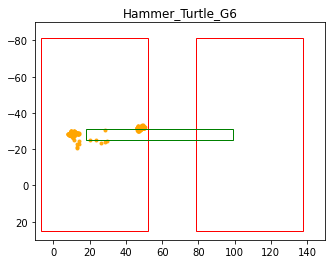

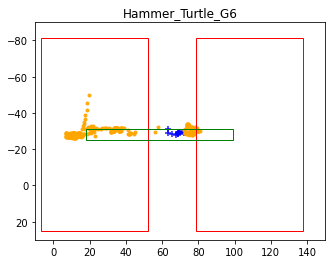

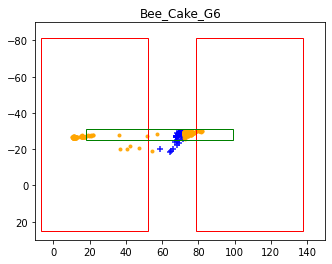

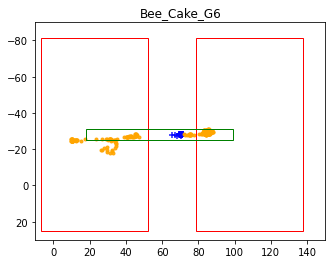

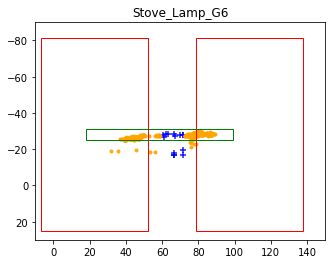

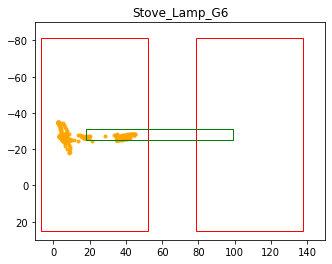

In [187]:
#Brian
Run_different(bdf, 'BrianP2')

# Chi-square test of independence of variables in a contingency table. (for references)

In [ ]:
exp = pd.read_csv('C:/Users/tsb7592/Box/Baby Toolbox Operations/Analysis/count.csv')

In [ ]:
#Getting the tsv counts 
exp =exp.iloc[:,:4]

In [ ]:
l1 =new40.to_numpy()
l2= exp.to_numpy()

In [ ]:
l2

In [ ]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

for i in range(24):
    data = [l1[i], l2[2]]
    
    stat, p, dof, expected = chi2_contingency(data)
    print(items[i])
    
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('')

In [ ]:
from scipy.stats import chisquare
chisq = pd.DataFrame(columns=('items', 'stat','p'))
for i in range(24):
    ob = obs.iloc[i]
    ex = expected.iloc[i]
    stat, pv = chisquare(f_obs=ob, f_exp=ex)
    chisq.loc[i] = [items[i], round(stat,3) ,round(pv,3)]


In [ ]:
chisq.to_csv('C:/Users/tsb7592/Box/Baby Toolbox Operations/Analysis/chisquare.csv', index=False)